# Hash-based Cross-Validation

## Why?
Often in machine learning we want to build not just one model but multiple iterations of models whilst the underlying data grows over time. To make comparing these models as simple as possible, we want to be able to create a number of train and test sets at time `t1` and again later at time `t2` and maximise the overlap between each train and test set. This package contains two cross-validators with sklearn 0.18+ interface that achieve this.

## How?
Splitting is based on labels with one label per row of data. These should be consistent over time (good examples may be user IDs or unique identifiers from a database table). Labels are hashed to uint32 using CRC32 which has relatively low collision for short, similar IDs. Then, [universal hashing](https://en.wikipedia.org/wiki/Universal_hashing) is used to evenly distribute the hashed labels over the full range of uint32 and to create different splits.

--------------

## Hash collision
Hash collisions are obviously a problem as two labels which get hashed to the same integer will always end up in the same split. However, the problem seems negligible, even for relatively short labels.

In [1]:
import numpy as np
from numpy.random import RandomState
from hashsplit.hashsplit import HashSplitMixin

n = 10**6
labels = ['item#%05d' % i for i in range(n)]

h0 = HashSplitMixin()._str_to_uint(labels)
n_h0 = len(np.unique(h0))
h1 = HashSplitMixin()._uni_hash(h0, RandomState(0))
n_h1 = len(np.unique(h1))

print('Unique hashes after string hashing: %d (%.2f%%)' % (n_h0, n_h0 / n * 100))
print('Unique hashes after re-hashing: %d (%.2f%%)' % (n_h1, n_h1 / n * 100))

Unique hashes after string hashing: 1000000 (100.00%)
Unique hashes after re-hashing: 999947 (99.99%)


## Overlap between sets
Below we create a train-test split for a data set A and an extended data set B and visualise the overlap.

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import ShuffleSplit
from hashsplit import HashShuffleSplit

%matplotlib inline

In [3]:
class DataSet():
    """ Creates a toy data set for splitting """
    def __init__(self, labels):
        self.labels = labels
        self.n = len(labels)
        self.X = np.random.rand(self.n, 10)
        self.y = np.random.choice([True, False], self.n)

all_labels = ['item#%05d' % i for i in range(10000)]
A = DataSet(all_labels[:8000])
B = DataSet(all_labels)

In [4]:
def plot_overlap(cv):
    _, test_A = next(iter(cv.split(A.X, A.y, A.labels)))
    _, test_B = next(iter(cv.split(B.X, B.y, B.labels)))
    
    is_test = np.zeros(B.n)
    is_test[test_A] += 1
    is_test[test_B] += 2
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

    axes[0].imshow(np.reshape((is_test[:A.n] == 1) | (is_test[:A.n] == 3), (-1, 100)))
    axes[0].set_title('Split A')
    axes[1].imshow(np.reshape((is_test[:B.n] >= 2), (-1, 100)))
    axes[1].set_title('Split B')
    axes[2].imshow(np.reshape((is_test[:A.n] == 3), (-1, 100)))
    axes[2].set_title('Test Set Overlap')

    for ax in axes:
        ax.set_anchor('N')
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.suptitle(cv.__class__.__name__)

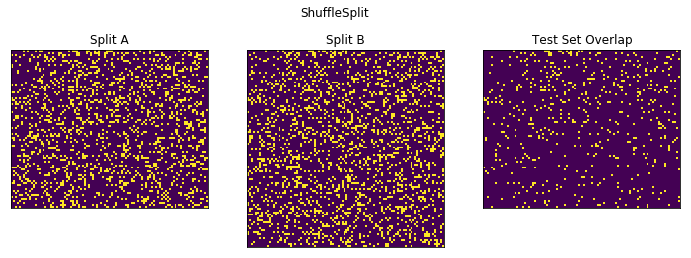

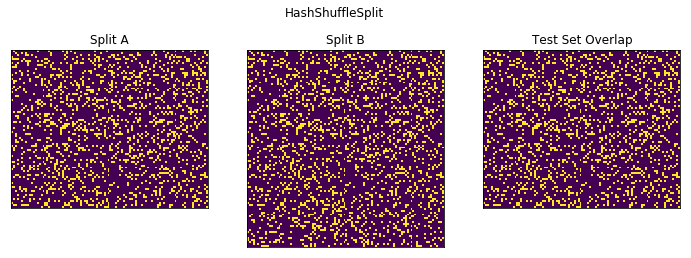

In [5]:
plot_overlap(ShuffleSplit(n_splits=1, test_size=0.2, random_state=0))
plot_overlap(HashShuffleSplit(n_splits=1, test_size=0.2, random_state=0))

## Distribution
If splitting works as intended, then how often a given sample ends up in the test set over a large number of splits should resemble a binomial distribution with the probability `test_size`. Similarly, the proportion of samples in the test size per split should follow the same distribution. We can see below that this is indeed the case.

In [6]:
from scipy.stats import binom

In [7]:
n = 10**4
labels = ['item#%05d' % i for i in range(n)]
A = DataSet(labels)

test_sizes = [0.25, 0.5, 0.75]
is_test = {}

for test_size in [0.25, 0.5, 0.75]:
    is_test[test_size] = np.zeros((n, n), dtype=bool)
    hss = HashShuffleSplit(n_splits=n, test_size=test_size)
    for i, (_, test_inds) in enumerate(hss.split(A.X, A.y, A.labels)):
        is_test[test_size][test_inds, i] = True

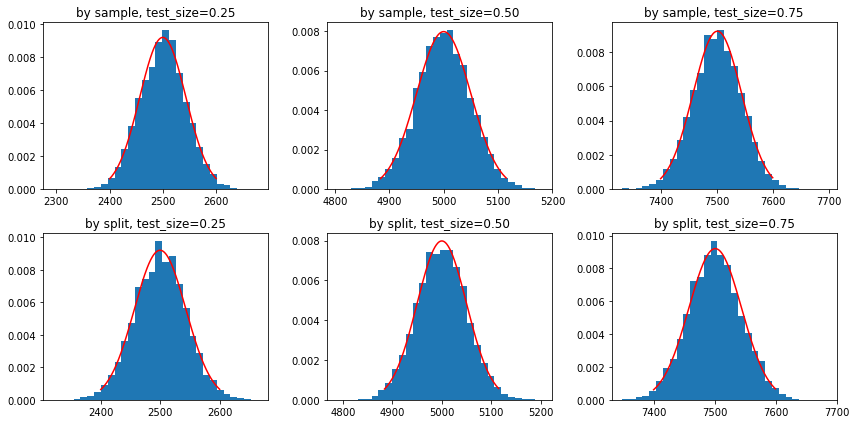

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i_size, test_size in enumerate(test_sizes):
    distr = binom(n, test_size)
    x = np.arange(distr.ppf(0.01), distr.ppf(0.99))
    
    # how often did a single sample end up in the test set over the number of splits?
    by_row = is_test[test_size].sum(axis=0)
    axes[0, i_size].hist(by_row, bins=30, normed=True)
    axes[0, i_size].plot(x, distr.pmf(x), 'r')
    axes[0, i_size].set_title('by sample, test_size=%.2f' % test_size)
    
    # how many test split samples did a single split contain?
    by_col = is_test[test_size].sum(axis=1)
    axes[1, i_size].hist(by_col, bins=30, normed=True)
    axes[1, i_size].plot(x, distr.pmf(x), 'r')
    axes[1, i_size].set_title('by split, test_size=%.2f' % test_size)
plt.tight_layout()

## Fineprint

In [9]:
%reload_ext watermark
%watermark -m -v -p numpy,sklearn

CPython 3.5.3
IPython 5.3.0

numpy 1.13.0
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
